### Context -

DRS bank is facing challenging times. Their NPAs (Non-Performing Assets) has been on a rise recently and a large part of these are due to the loans given to individual customers(borrowers). Chief Risk Officer of the bank decides to put in a scientifically robust framework for approval of loans to individual customers to minimize the risk of loans converting into NPAs and initiates a project for the data science team at the bank. You, as a senior member of the team, are assigned this project.

### Objective -
To identify the criteria to approve loans for an individual customer such that the likelihood of the loan delinquency is minimized

### Key questions to be answered –
What are the factors that drive the behavior of loan delinquency?

#### Dataset:
* ID: Customer ID
* isDelinquent : indicates whether the customer is delinquent or not (1 => Yes, 0 => No)
* term: Loan term in months
* gender: Gender of the borrower
* age: Age of the borrower
* purpose: Purpose of Loan
* home_ownership: Status of borrower's home
* FICO: FICO (i.e. the bureau score) of the borrower

### Domain Information –
Transactor – A person who pays his due amount balance full and on time.
Revolver – A person who pays the minimum due amount but keeps revolving his balance and does not pay the full amount.
Delinquent - Delinquency means that you are behind on payments, a person who fails to pay even the minimum due amount.
Defaulter – Once you are delinquent for a certain period your lender will declare you to be in the default stage.
Risk Analytics – A wide domain in the financial and banking industry, basically analyzing the risk of the customer.


### Import the necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

### Read the dataset

In [2]:
data=pd.read_csv("Loan_Delinquent_Dataset.csv")

In [3]:
# copying data to another varaible to avoid any changes to original data
loan=data.copy()

### View the first and last 5 rows of the dataset.

In [4]:
loan.head()

,ID,isDelinquent,term,gender,purpose,home_ownership,age,FICO
0,1,1,36 months,Female,House,Mortgage,>25,300-500
1,2,0,36 months,Female,House,Rent,20-25,>500
2,3,1,36 months,Female,House,Rent,>25,300-500
3,4,1,36 months,Female,Car,Mortgage,>25,300-500
4,5,1,36 months,Female,House,Rent,>25,300-500


In [5]:
loan.tail()

,ID,isDelinquent,term,gender,purpose,home_ownership,age,FICO
11543,11544,0,60 months,Male,other,Mortgage,>25,300-500
11544,11545,1,36 months,Male,House,Rent,20-25,300-500
11545,11546,0,36 months,Female,Personal,Mortgage,20-25,>500
11546,11547,1,36 months,Female,House,Rent,20-25,300-500
11547,11548,1,36 months,Male,Personal,Mortgage,20-25,300-500


### Understand the shape of the dataset.

In [6]:
loan.shape

(11548, 8)

* The dataset has 11548 rows and 8 columns of data

### Check the data types of the columns for the dataset.

In [7]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11548 entries, 0 to 11547
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              11548 non-null  int64 
 1   isDelinquent    11548 non-null  int64 
 2   term            11548 non-null  object
 3   gender          11548 non-null  object
 4   purpose         11548 non-null  object
 5   home_ownership  11548 non-null  object
 6   age             11548 non-null  object
 7   FICO            11548 non-null  object
dtypes: int64(2), object(6)
memory usage: 721.9+ KB


## Fixing the data types

* term,gender,purpose,home_ownership,age anf FICO are of object type, we can change them to categories.

`converting "objects" to "category" reduces the data space required to store the dataframe`

In [8]:
loan["term"] = loan["term"].astype("category")
loan["gender"] = loan["gender"].astype("category")
loan["purpose"] = loan["purpose"].astype("category")
loan["home_ownership"] = loan["home_ownership"].astype("category")
loan["age"] = loan["age"].astype("category")
loan["FICO"] = loan["FICO"].astype("category")

In [9]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11548 entries, 0 to 11547
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              11548 non-null  int64   
 1   isDelinquent    11548 non-null  int64   
 2   term            11548 non-null  category
 3   gender          11548 non-null  category
 4   purpose         11548 non-null  category
 5   home_ownership  11548 non-null  category
 6   age             11548 non-null  category
 7   FICO            11548 non-null  category
dtypes: category(6), int64(2)
memory usage: 249.1 KB


`we can see that the memory usage has decreased from 721.9KB to 249.1KB`

**Observations -**
* isDelinquent is the dependent variable - type integer.
* isDelinquent is a class variable and should be converted to a categorical variable for further analysis.
* All the dependent variables except for ID are categorical.


In [10]:
loan["isDelinquent"] = loan["isDelinquent"].astype("category")

### Summary of the dataset.

In [11]:
loan.describe(include="all")

,ID,isDelinquent,term,gender,purpose,home_ownership,age,FICO
count,11548.000000,11548.0,11548,11548,11548,11548,11548,11548
unique,NaN,2.0,2,2,7,3,2,2
top,NaN,1.0,36 months,Male,House,Mortgage,20-25,300-500
freq,NaN,7721.0,10589,6555,6892,5461,5888,6370
mean,5774.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,3333.764789,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2887.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5774.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,8661.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Observations-**   

* Most of the customers are loan delinquent(1).
* Most of the loans are for a 36-month term loan.
* More males have applied for loans than females.
* Most loan applications are for house loans.
* Most customers have either mortgaged their houses.
* Mostly customers in the age group 20-25 have applied for a loan.
* Most customers have a FICO score between 300 and 500.

In [12]:
# checking for unique values in ID column
loan["ID"].nunique()

11548

* Since all the values in ID column are unique we can drop it

In [13]:
loan.drop(["ID"],axis=1,inplace=True)

### Check for missing values

In [14]:
loan.isnull().sum()

isDelinquent      0
term              0
gender            0
purpose           0
home_ownership    0
age               0
FICO              0
dtype: int64

* There are no missing vaues in out dataset

### Univariate analysis

In [15]:
# Function to create barplots that indicate percentage for each category.

def perc_on_bar(plot, feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

## Observations on isDelinquent

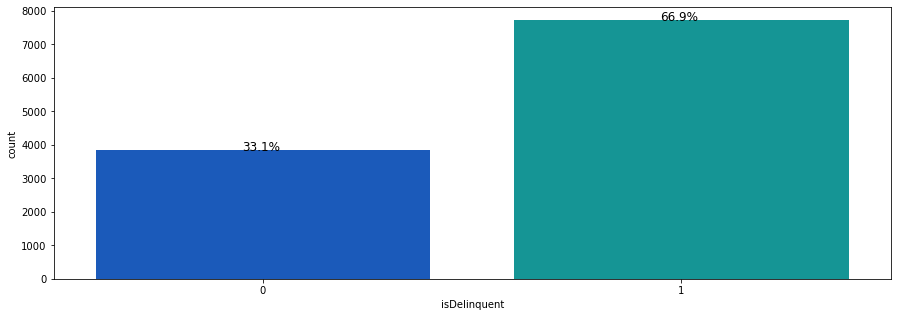

In [16]:
plt.figure(figsize=(15,5))
ax = sns.countplot(loan["isDelinquent"],palette='winter')
perc_on_bar(ax,loan["isDelinquent"])

* 66% of the customers are delinquent

## Observations on term

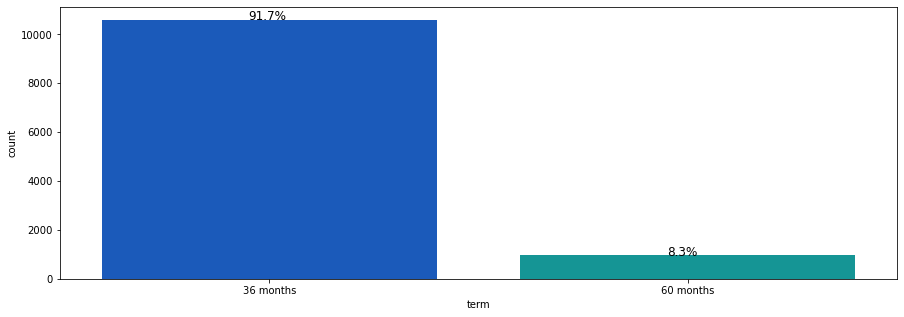

In [17]:
plt.figure(figsize=(15,5))
ax = sns.countplot(loan["term"],palette='winter')
perc_on_bar(ax,loan["term"])

* 91.7% of the loans are for a 36 month term.

## Observations on gender

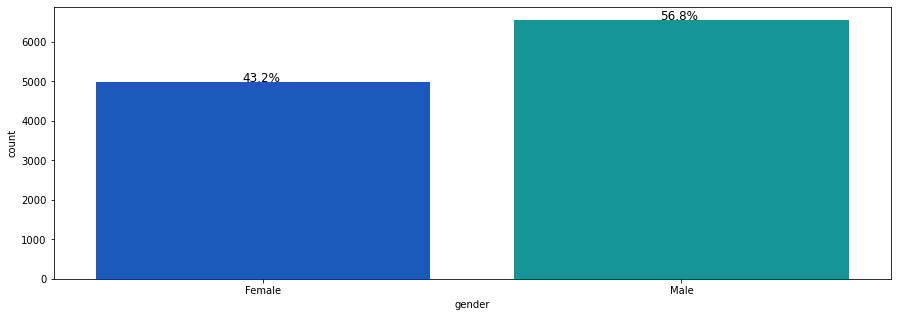

In [18]:
plt.figure(figsize=(15,5))
ax = sns.countplot(loan["gender"],palette='winter')
perc_on_bar(ax,loan["gender"])

* There are more male applicants (56.8%) than female applicants (43.2%)

## Observations on purpose

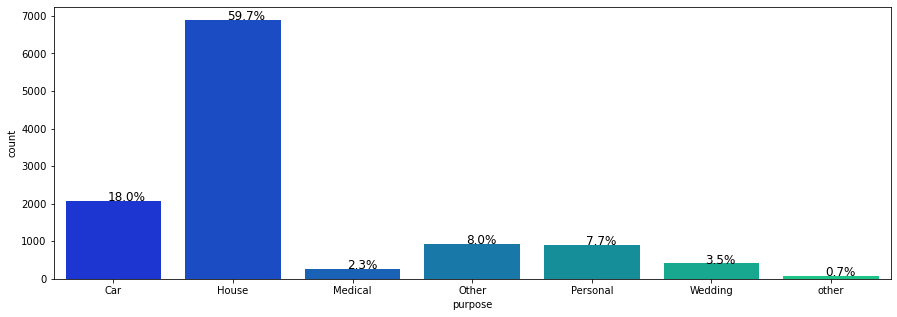

In [19]:
plt.figure(figsize=(15,5))
ax = sns.countplot(loan["purpose"],palette='winter')
perc_on_bar(ax,loan["purpose"])

* Most loan applications are for house loans (59.7%) followed by car loans (18%)
* There are 2 levels named 'other' and 'Other' under the purpose variable. Since we do not have any other information about these, we can merge these levels.

## Observations on home_ownership

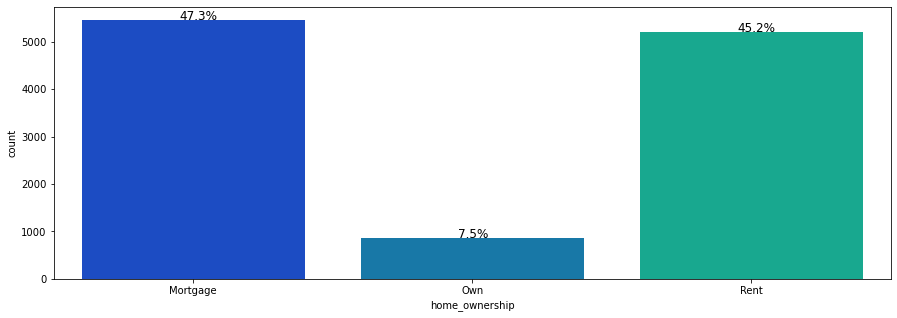

In [20]:
plt.figure(figsize=(15,5))
ax = sns.countplot(loan["home_ownership"],palette='winter')
perc_on_bar(ax,loan["home_ownership"])

* Very few applicants <10% own their house, Most customers have either mortgaged their houses or live on rent. 

## Observations on age

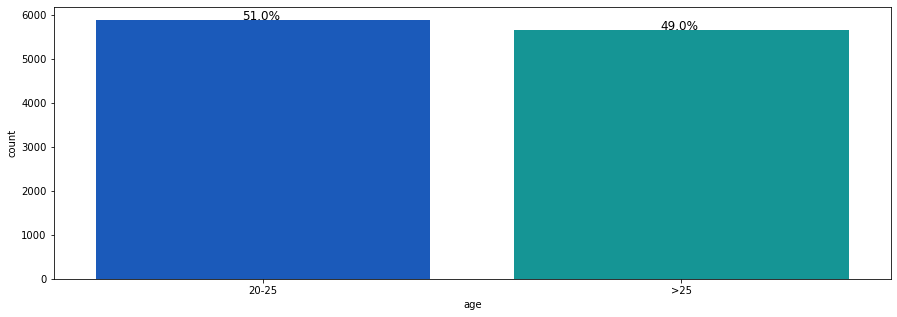

In [21]:
plt.figure(figsize=(15,5))
ax = sns.countplot(loan["age"],palette='winter')
perc_on_bar(ax,loan["age"])

* Almost an equal percentage of people aged 20-25 and >25 have applied for the loan.

## Observations on FICO

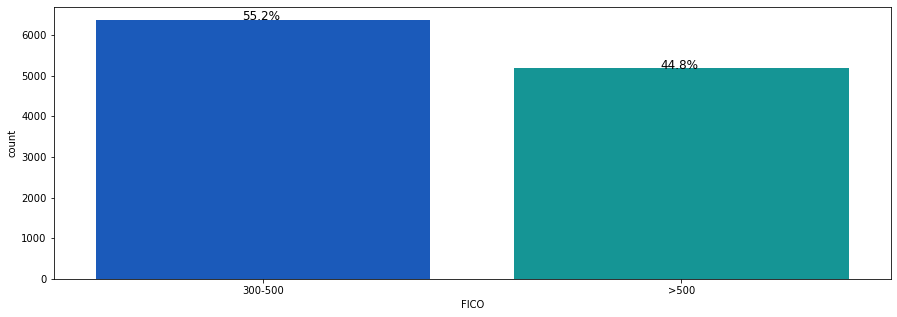

In [22]:
plt.figure(figsize=(15,5))
ax = sns.countplot(loan["FICO"],palette='winter')
perc_on_bar(ax,loan["FICO"])

* Most customers have a FICO score between 300 and 500 (55.2%) followed by a score of greater than 500 (44.8%)

## Data Cleaning

In [23]:
loan["purpose"].unique()

[House, Car, Other, Personal, Wedding, Medical, other]
Categories (7, object): [House, Car, Other, Personal, Wedding, Medical, other]

### We can merge the purpose -  'other' and 'Other' together

In [24]:
loan["purpose"].replace('other',"Other",inplace=True)

In [25]:
loan["purpose"].unique()

[House, Car, Other, Personal, Wedding, Medical]
Categories (6, object): [House, Car, Other, Personal, Wedding, Medical]

## Bivariate Analysis

In [26]:
## Function to plot stacked bar chart
def stacked_plot(x):
    sns.set(palette='nipy_spectral')
    tab1 = pd.crosstab(x,loan['isDelinquent'],margins=True)
    print(tab1)
    print('-'*120)
    tab = pd.crosstab(x,loan['isDelinquent'],normalize='index')
    tab.plot(kind='bar',stacked=True,figsize=(10,5))
    #plt.legend(loc='lower left', frameon=False)
    #plt.legend(loc="upper left", bbox_to_anchor=(0,1))
    plt.show()

isDelinquent     0     1    All
term                           
36 months     3168  7421  10589
60 months      659   300    959
All           3827  7721  11548
------------------------------------------------------------------------------------------------------------------------


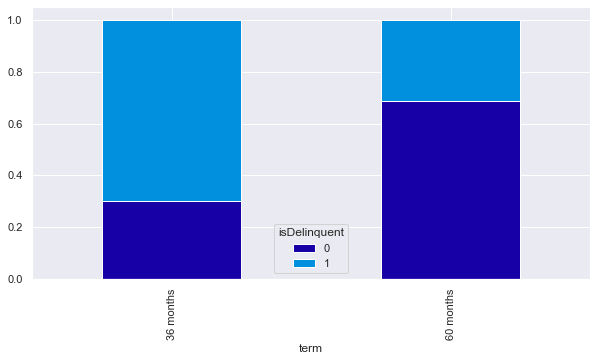

In [27]:
stacked_plot(loan['term'])

* Most loan delinquent customers have taken loan for 36 months.

isDelinquent     0     1    All
gender                         
Female        1850  3143   4993
Male          1977  4578   6555
All           3827  7721  11548
------------------------------------------------------------------------------------------------------------------------


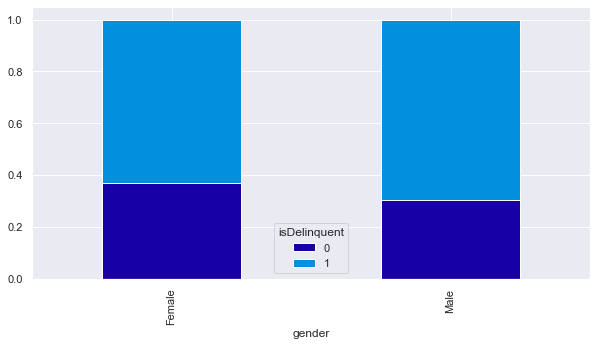

In [28]:
stacked_plot(loan['gender'])

* There's not much difference between male and female customers.

isDelinquent     0     1    All
purpose                        
Car            678  1402   2080
House         2272  4620   6892
Medical        107   159    266
Other          357   653   1010
Personal       274   618    892
Wedding        139   269    408
All           3827  7721  11548
------------------------------------------------------------------------------------------------------------------------


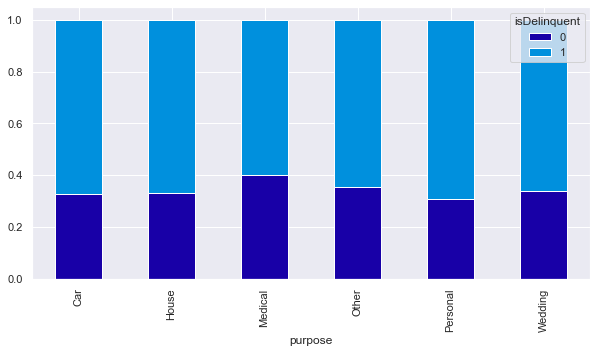

In [29]:
stacked_plot(loan['purpose'])

* Most loan delinquent customers are those who have applied for house loans followed by car and personal loans.

isDelinquent       0     1    All
home_ownership                   
Mortgage        1831  3630   5461
Own              259   612    871
Rent            1737  3479   5216
All             3827  7721  11548
------------------------------------------------------------------------------------------------------------------------


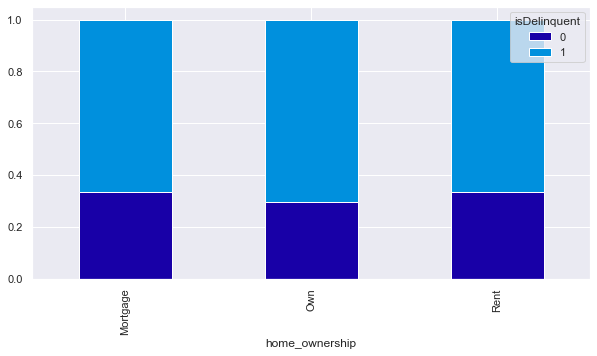

In [30]:
stacked_plot(loan['home_ownership'])

* Those customers who have their own house are less delinquent than the ones who live in a rented place or have mortgaged their home.

isDelinquent     0     1    All
age                            
20-25         1858  4030   5888
>25           1969  3691   5660
All           3827  7721  11548
------------------------------------------------------------------------------------------------------------------------


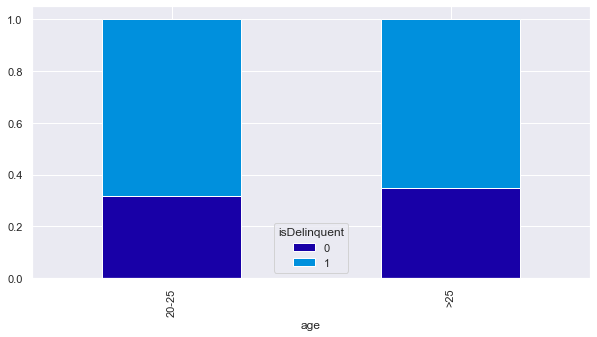

In [31]:
stacked_plot(loan['age'])

* Customers between 20-25 years of age are more delinquent.

isDelinquent     0     1    All
FICO                           
300-500        941  5429   6370
>500          2886  2292   5178
All           3827  7721  11548
------------------------------------------------------------------------------------------------------------------------


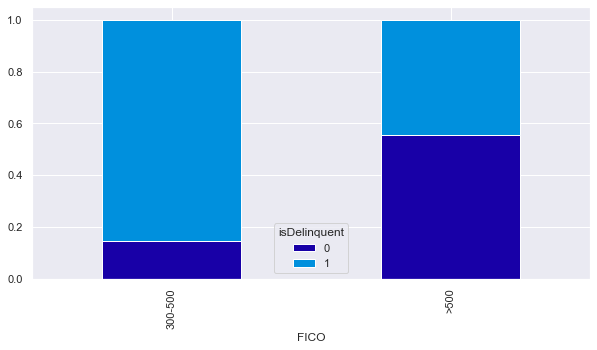

In [32]:
stacked_plot(loan['FICO'])

* If FICO score is >500 the chances of delinquency decrease quite a lot compared to when FICO score is between 300-500.

### Key Observations - 
* FICO score and term of loan application appear to be very strong indicators of delinquency.

* Other factors appear to be not very good indicators of delinquency. (We can use chi-square tests to determine statistical significance in the association between two categorical variables).

### We observed that a high FICO score means that the chances of delinquency are lower, let us see  if any of the other variables indicate higher a FICO score.

In [33]:
def stacked_plot_FICO(x):
    sns.set(palette='nipy_spectral')
    tab1 = pd.crosstab(x,loan['FICO'],margins=True)
    print(tab1)
    print('-'*120)
    tab = pd.crosstab(x,loan['FICO'],normalize='index')
    tab.plot(kind='bar',stacked=True,figsize=(10,5))
    #plt.legend(loc='lower left', frameon=False)
    #plt.legend(loc="upper left", bbox_to_anchor=(0,1))
    plt.show()

FICO            300-500  >500    All
home_ownership                      
Mortgage           2857  2604   5461
Own                 480   391    871
Rent               3033  2183   5216
All                6370  5178  11548
------------------------------------------------------------------------------------------------------------------------


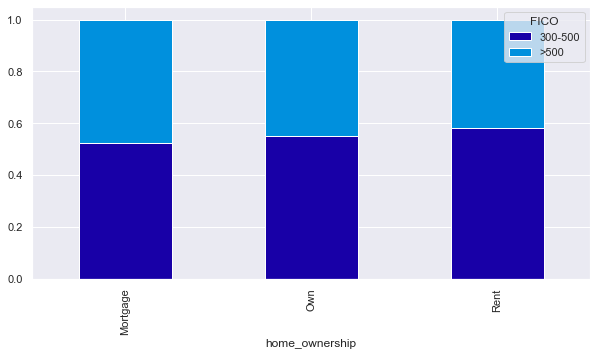

In [34]:
stacked_plot_FICO(loan['home_ownership'])

FICO   300-500  >500    All
age                        
20-25     3927  1961   5888
>25       2443  3217   5660
All       6370  5178  11548
------------------------------------------------------------------------------------------------------------------------


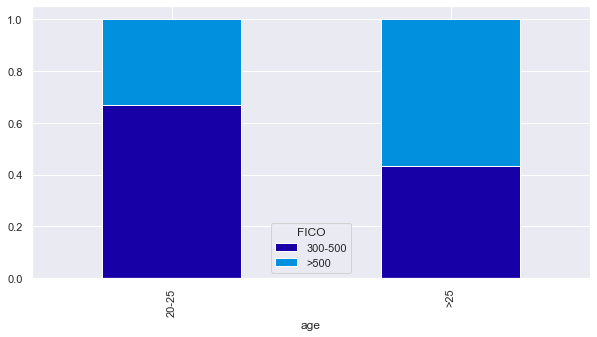

In [35]:
stacked_plot_FICO(loan['age'])

FICO    300-500  >500    All
gender                      
Female     2665  2328   4993
Male       3705  2850   6555
All        6370  5178  11548
------------------------------------------------------------------------------------------------------------------------


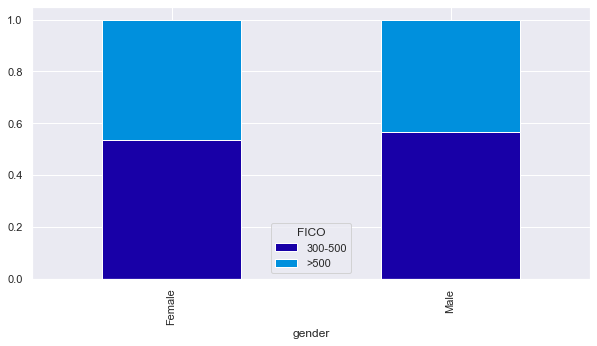

In [36]:
stacked_plot_FICO(loan['gender'])

## Key Observations

1. Home ownership and gender seem to have a slight impact on the FICO scores.
2. Age seems to have a much bigger impact on FICO scores.

### Let us check which of these differences are statistically significant.

The Chi-Square test is a statistical method to determine if two categorical variables have a significant correlation between them.
  
**Null Hypothesis -** There is no association between the two variables.      
**Alternate Hypothesis -** There is an association between two variables.

In [37]:
crosstab = pd.crosstab(loan['FICO'],loan['home_ownership'])  # Contingency table of region and smoker attributes

Ho = "FICO score has no effect on home ownership"   # Stating the Null Hypothesis
Ha = "FICO score has an effect on home ownership"   # Stating the Alternate Hypothesis

chi, p_value, dof, expected =  stats.chi2_contingency(crosstab)

if p_value < 0.05:  # Setting our significance level at 5%
    print(f'{Ha} as the p_value ({p_value.round(3)}) < 0.05')
else:
    print(f'{Ho} as the p_value ({p_value.round(3)}) > 0.05')

FICO score has an effect on home ownership as the p_value (0.0) < 0.05


In [38]:
crosstab = pd.crosstab(loan['FICO'],loan['gender'])  # Contingency table of region and smoker attributes

Ho = "FICO score has no effect on gender"   # Stating the Null Hypothesis
Ha = "FICO score has an effect on gender"   # Stating the Alternate Hypothesis

chi, p_value, dof, expected =  stats.chi2_contingency(crosstab)

if p_value < 0.05:  # Setting our significance level at 5%
    print(f'{Ha} as the p_value ({p_value.round(3)}) < 0.05')
else:
    print(f'{Ho} as the p_value ({p_value.round(3)}) > 0.05')

FICO score has an effect on gender as the p_value (0.001) < 0.05


In [39]:
crosstab = pd.crosstab(loan['FICO'],loan['age'])  # Contingency table of region and smoker attributes

Ho = "FICO score has no effect on age"   # Stating the Null Hypothesis
Ha = "FICO score has an effect on age"   # Stating the Alternate Hypothesis

chi, p_value, dof, expected =  stats.chi2_contingency(crosstab)

if p_value < 0.05:  # Setting our significance level at 5%
    print(f'{Ha} as the p_value ({p_value.round(3)}) < 0.05')
else:
    print(f'{Ho} as the p_value ({p_value.round(3)}) > 0.05')

FICO score has an effect on age as the p_value (0.0) < 0.05


## Key Observations-

* P-value for all tests < 0.01. Hence, all the differences that we see in the 3 plots are statistically significant.
* There is a correlation between FICO Score and house_ownership. People who have mortgaged their houses have higher FICO scores than people who own the house (peculiar!).
* There is a correlation between FICO Score and gender. More females have >500 FICO scores as compared to Males.
* There is a correlation between FICO Score and age. People >25 years of age have higher FICO scores as compared to people of age 20-25. 

## Model Building - Approach
1. Data preparation
2. Partition the data into train and test set.
3. Build a model on the train data.
4. Tune the model and prune the tree, if required.
5. Test the data on test set.

## Split Data

In [40]:
x = loan.drop(["isDelinquent"], axis=1)
y = loan["isDelinquent"]

In [41]:
# encoding the categorical variables
x = pd.get_dummies(x, drop_first=True)
x.head()

,term_60 months,gender_Male,purpose_House,purpose_Medical,purpose_Other,purpose_Personal,purpose_Wedding,home_ownership_Own,home_ownership_Rent,age_>25,FICO_>500
0,0,0,1,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,1,0,1
2,0,0,1,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,1,1,0


In [42]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3 , random_state=7,stratify=y)

In [43]:
y.value_counts(1)

1    0.668601
0    0.331399
Name: isDelinquent, dtype: float64

In [44]:
y_train.value_counts(1)

1    0.668564
0    0.331436
Name: isDelinquent, dtype: float64

**What does a bank want?**
* A bank wants to minimize the loss - it can face 2 types of losses here: 
   * Whenever a bank lends money to a customer, they don't return that.
   * A bank doesn't lend money to a customer thinking a customer will default but in reality, the customer won't - opportunity loss.

**Which loss is greater ?**
* Lending to a customer who wouldn't be able to pay back.

**Since we want to reduce loan delinquency we should use Recall as a metric of model evaluation instead of accuracy.**

* Recall - It gives the ratio of True positives to Actual positives, so high Recall implies low false negatives, i.e. low chances of predicting loan-delinquent customers as a non-loan-delinquent customer.

In [45]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,train,test,train_y,test_y,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    train_acc = model.score(train,train_y)
    test_acc = model.score(test,test_y)
    
    train_recall = metrics.recall_score(train_y,pred_train)
    test_recall = metrics.recall_score(test_y,pred_test)
    
    train_precision = metrics.precision_score(train_y,pred_train)
    test_precision = metrics.precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(train,train_y))
        print("Accuracy on test set : ",model.score(test,test_y))
        print("Recall on training set : ",metrics.recall_score(train_y,pred_train))
        print("Recall on test set : ",metrics.recall_score(test_y,pred_test))
        print("Precision on training set : ",metrics.precision_score(train_y,pred_train))
        print("Precision on test set : ",metrics.precision_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

In [46]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Logistic Regression 

In [47]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train,y_train)

LogisticRegression(random_state=1)

**Let's evaluate the model performance by using KFold and cross_val_score**

- `K-Folds cross-validator` provides dataset indices to split data into train/validation sets. Split dataset into k consecutive stratified folds (without shuffling by default). Each fold is then used once as validation while the k - 1 remaining folds form the training set.

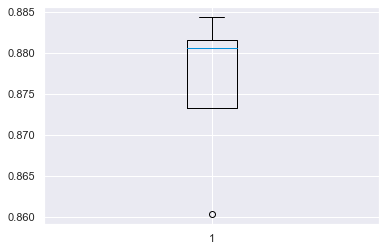

In [48]:
scoring='recall'
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=lr, X=X_train, y=y_train, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

* Performance on training set varies between 0.86 to 0.86 recall.
* Let's check the performance on test data.

Accuracy on training set :  0.7834962266485216
Accuracy on test set :  0.7948051948051948
Recall on training set :  0.877498149518875
Recall on test set :  0.8813120414328873
Precision on training set :  0.8133790737564323
Precision on test set :  0.8240516545601292


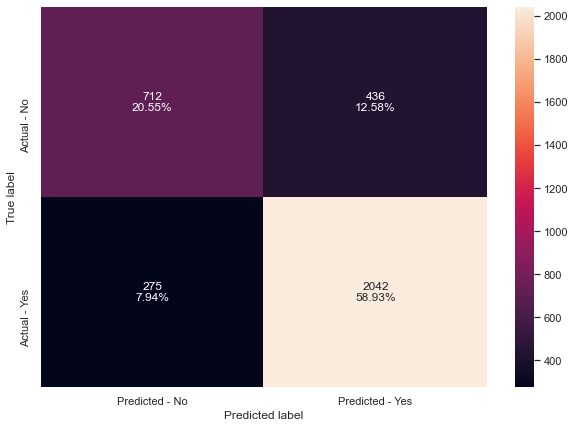

In [49]:
#Calculating different metrics
scores_LR = get_metrics_score(lr,X_train,X_test,y_train,y_test)

# creating confusion matrix
make_confusion_matrix(lr,y_test)

* Logistic Regression has given a generalized performance on training and test set.
* Recall is very also very good, let's see if the model performance can be further improved by:

  a) Oversampling - getting more data points for the minority class.
  
  b) Undersampling - dealing with the class imbalance.

### Oversampling train data using SMOTE

In [50]:
from imblearn.over_sampling import SMOTE

In [51]:
print("Before UpSampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label 'No': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over==0)))


print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

Before UpSampling, counts of label 'Yes': 5404
Before UpSampling, counts of label 'No': 2679 

After UpSampling, counts of label 'Yes': 5404
After UpSampling, counts of label 'No': 5404 

After UpSampling, the shape of train_X: (10808, 11)
After UpSampling, the shape of train_y: (10808,) 



### Logistic Regression on oversampled data

In [52]:
log_reg_over = LogisticRegression(random_state = 1)

# Training the basic logistic regression model with training set 
log_reg_over.fit(X_train_over,y_train_over)

LogisticRegression(random_state=1)

**Let's evaluate the model performance by using KFold and cross_val_score**

- `K-Folds cross-validator` provides dataset indices to split data into train/validation sets. Split dataset into k consecutive stratified folds (without shuffling by default). Each fold is then used once as validation while the k - 1 remaining folds form the training set.

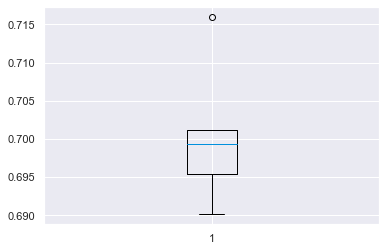

In [53]:
scoring='recall'
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)     #Setting number of splits equal to 5
cv_result_over=cross_val_score(estimator=log_reg_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_over)
plt.show()

* Performance on training set varies between 0.69 to 0.72 recall.
* Let's check the performance on test data.

Accuracy on training set :  0.7721132494448557
Accuracy on test set :  0.7523809523809524
Recall on training set :  0.7004071058475203
Recall on test set :  0.7095381959430298
Precision on training set :  0.8176712032836466
Precision on test set :  0.8988518316019682


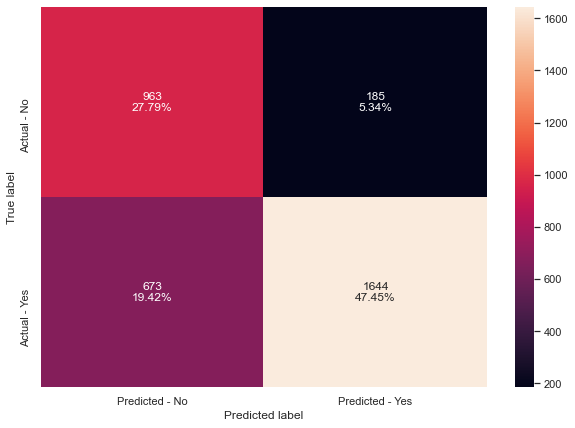

In [54]:
#Calculating different metrics
get_metrics_score(log_reg_over,X_train_over,X_test,y_train_over,y_test)

# creating confusion matrix
make_confusion_matrix(log_reg_over,y_test)

* Logistic Regression has given a generalized performance on training and test set.
* Recall is very also good, but it has decreased from the initial logistic model.
* Let's see if regualarization/tuning can make the model performance better.

### Regularization

In [55]:
# Choose the type of classifier. 
lr_estimator = LogisticRegression(random_state=1,solver='saga')

# Grid of parameters to choose from
parameters = {'C': np.arange(0.1,1.1,0.1)}

# Run the grid search
grid_obj = GridSearchCV(lr_estimator, parameters, scoring='recall')
grid_obj = grid_obj.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
lr_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
lr_estimator.fit(X_train_over, y_train_over)

LogisticRegression(C=0.1, random_state=1, solver='saga')

Accuracy on training set :  0.7244633604737232
Accuracy on test set :  0.7292929292929293
Recall on training set :  0.7004071058475203
Recall on test set :  0.7095381959430298
Precision on training set :  0.7358087091757387
Precision on test set :  0.8611838658983761


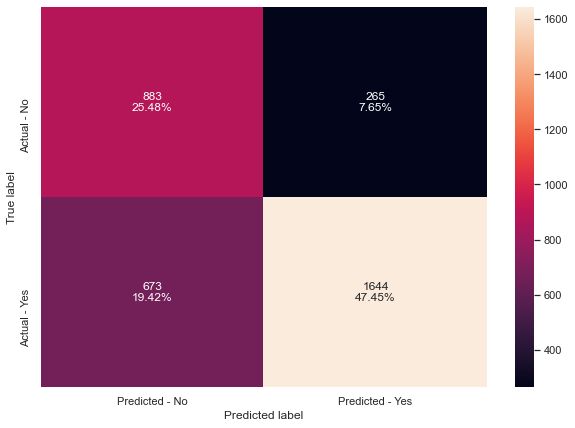

In [56]:
#Calculating different metrics
get_metrics_score(lr_estimator,X_train_over,X_test,y_train_over,y_test)

# creating confusion matrix
make_confusion_matrix(lr_estimator,y_test)

* Model performance hasn't improved much after regularization.

### Undersampling train data using SMOTE

In [57]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [58]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train==0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un==1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un==0)))

print('After Under Sampling, the shape of train_X: {}'.format(X_train_un.shape))
print('After Under Sampling, the shape of train_y: {} \n'.format(y_train_un.shape))

Before Under Sampling, counts of label 'Yes': 5404
Before Under Sampling, counts of label 'No': 2679 

After Under Sampling, counts of label 'Yes': 2679
After Under Sampling, counts of label 'No': 2679 

After Under Sampling, the shape of train_X: (5358, 11)
After Under Sampling, the shape of train_y: (5358,) 



### Logistic Regression on undersampled data

In [59]:
log_reg_under = LogisticRegression(random_state = 1)
log_reg_under.fit(X_train_un,y_train_un )

LogisticRegression(random_state=1)

**Let's evaluate the model performance by using KFold and cross_val_score**

- `K-Folds cross-validator` provides dataset indices to split data into train/validation sets. Split dataset into k consecutive stratified folds (without shuffling by default). Each fold is then used once as validation while the k - 1 remaining folds form the training set.

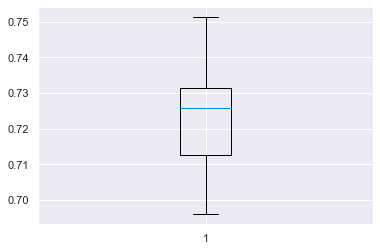

In [60]:
scoring='recall'
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)     #Setting number of splits equal to 5
cv_result_under=cross_val_score(estimator=log_reg_under, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_under)
plt.show()

* Performance of model on training set varies between 0.69 to 0.75.
* Let's check the performance on the test set.

Accuracy on training set :  0.7797685703620754
Accuracy on test set :  0.7598845598845598
Recall on training set :  0.7222844344904815
Recall on test set :  0.7237807509710833
Precision on training set :  0.8161113454238718
Precision on test set :  0.8972712680577849


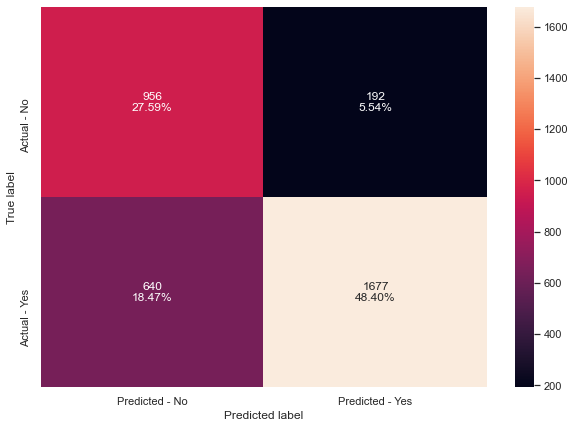

In [61]:
#Calculating different metrics
get_metrics_score(log_reg_under,X_train_un,X_test,y_train_un,y_test)


# creating confusion matrix
make_confusion_matrix(log_reg_under,y_test)

* Model has given a generalized performance on training and test set.
* Model performance has not improved much-using downsampling.

In [62]:
# defining list of model
models = [lr]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:
    
    j = get_metrics_score(model,X_train,X_test,y_train,y_test,False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

In [63]:
# defining list of models
models = [log_reg_over, lr_estimator]

# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:
    
    j = get_metrics_score(model,X_train_over,X_test,y_train_over,y_test,False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

In [64]:
# defining list of model
models = [log_reg_under]

# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:
    
    j = get_metrics_score(model,X_train_un,X_test,y_train_un,y_test,False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

In [65]:
comparison_frame = pd.DataFrame({'Model':['Logistic Regression','Logistic Regression on Oversampled data',
                                          'Logistic Regression-Regularized (Oversampled data)','Logistic Regression on Undersampled data'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 

#Sorting models in decreasing order of test recall
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Logistic Regression,0.783496,0.794805,0.877498,0.881312,0.813379,0.824052
1,Logistic Regression on Oversampled data,0.772113,0.752381,0.700407,0.709538,0.817671,0.898852
2,Logistic Regression-Regularized (Oversampled d...,0.724463,0.729293,0.700407,0.709538,0.735809,0.861184
3,Logistic Regression on Undersampled data,0.779769,0.759885,0.722284,0.723781,0.816111,0.897271


* Initial logistic regression with sampling and regularization has given a generalized performance on training and test set.

### Finding the coefficients

In [66]:
log_odds = lr.coef_[0]
pd.DataFrame(log_odds, X_train_un.columns, columns=['coef'])

,coef
term_60 months,-2.119256
gender_Male,0.779883
purpose_House,0.044907
purpose_Medical,0.349555
purpose_Other,-0.012553
purpose_Personal,0.093063
purpose_Wedding,0.099329
home_ownership_Own,0.158061
home_ownership_Rent,-0.109600
age_>25,0.588960


###  Converting coefficients to odds

In [67]:
odds = np.exp(np.abs(lr.coef_[0]))-1
pd.set_option('display.max_rows',None)
pd.DataFrame(odds, X_train_un.columns, columns=['Change in odds'])

,Change in odds
term_60 months,7.324945
gender_Male,1.181217
purpose_House,0.045931
purpose_Medical,0.418437
purpose_Other,0.012632
purpose_Personal,0.097531
purpose_Wedding,0.104429
home_ownership_Own,0.171238
home_ownership_Rent,0.115832
age_>25,0.802114


### Conclusion

* term: The change in odds of a customer who takes a loan for 60 months being a delinquent customer is 73.2% lower than a person who takes a loan for 36 months.

* gender: The change in odds of a male customer being a delinquent customer is 118% higher than a female customer.

* purpose: 
  * The odds of a customer who is seeking a loan for a house being a delinquent customer is 4.5% higher than a customer who is seeking a loan for a car. (keeping purpose_car as reference).

  * The odds of a customer who is seeking a loan for medical reasons being a delinquent customer is 41% higher than a customer who is seeking a loan for a car. (keeping purpose_car as reference).
  
  * The odds of a customer who is seeking a loan for other reasons being a delinquent customer is 1.2% lower than a customer who is seeking a loan for a car. (keeping purpose_car as reference).
  
`Interpretation for other attributes can be made similarly.`

* age: The odds of a customer above 25 years being a delinquent customer is 80% higher than the customers in the age group 20-25.

* FICO: The odds of a customer with a FICO score above 500 being a delinquent customer is 86% lower than a customer with a FICO score between 300 to 500.

## Business Insights

* FICO, term and gender are the  important variables in determining if a borrower will get into a delinquent stage 
* No borrower shall be given a loan if they are applying for a 36 month term loan and have a FICO score in the range 300-500.
* Female borrowers with a FICO score greater than 500 should be our target customers.
* Criteria to approve loan according to decision tree model should depend on three main factors - FICO score, duration of loan and gender that is - If the FICO score is less than 500 and the duration of loan is less than 60 months then the customer will not be able to repay the loans. If the customer has greater than 500 FICO score and is a female higher chances that they will repay the loans.